
# Training log visualization

This notebook reads the training logs stored under `outputs/*` (either `train_logs.json` or `checkpoint-*/trainer_state.json`), normalizes them, and plots a handful of key metrics per run. Metric selection adapts to SFT/LoRA logs (loss/accuracy/entropy), DPO-style preference logs (loss/rewards/log-prob gaps), and GRPO-like logs (reward/KL/entropy) when those signals are present.


In [1]:

from pathlib import Path
import json

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
BASE_DIR = Path.cwd()
OUTPUTS_DIR = BASE_DIR / "outputs"


## Helpers

In [2]:

RUNTIME_COL_KEYS = ("runtime", "per_second")
SUMMARY_COLS = {"total_flos"}


def find_latest_trainer_state(model_dir: Path):
    checkpoints = []
    for checkpoint in model_dir.glob("checkpoint-*"):
        try:
            step = int(checkpoint.name.split("-")[-1])
        except ValueError:
            continue
        state_path = checkpoint / "trainer_state.json"
        if state_path.exists():
            checkpoints.append((step, state_path))
    if not checkpoints:
        return None
    checkpoints.sort(key=lambda item: item[0], reverse=True)
    return checkpoints[0][1]


def load_raw_logs(model_dir: Path):
    train_log_path = model_dir / "train_logs.json"
    if train_log_path.exists():
        return json.loads(train_log_path.read_text()), train_log_path.name

    trainer_state_path = find_latest_trainer_state(model_dir)
    if trainer_state_path:
        state = json.loads(trainer_state_path.read_text())
        return state.get("log_history", []), f"{trainer_state_path.parent.name}/{trainer_state_path.name}"

    raise FileNotFoundError(f"No train logs found in {model_dir}")


def clean_and_prepare_df(log_entries):
    df = pd.DataFrame(log_entries)
    if df.empty:
        return df
    if "step" not in df.columns:
        df["step"] = range(len(df))
    df["step"] = pd.to_numeric(df["step"], errors="coerce")

    runtime_cols = [c for c in df.columns if any(key in c for key in RUNTIME_COL_KEYS) or c in SUMMARY_COLS]
    if runtime_cols:
        runtime_mask = pd.DataFrame({c: df[c].notna() for c in runtime_cols}).any(axis=1)
        df = df.loc[~runtime_mask]
        df = df.drop(columns=runtime_cols, errors="ignore")

    df = df.drop_duplicates(subset="step", keep="last")
    df = df.sort_values("step").reset_index(drop=True)
    return df


def augment_metrics(df: pd.DataFrame):
    df = df.copy()
    if {"logps/chosen", "logps/rejected"}.issubset(df.columns):
        df["logps_gap"] = df["logps/chosen"] - df["logps/rejected"]
    if {"logits/chosen", "logits/rejected"}.issubset(df.columns):
        df["logits_gap"] = df["logits/chosen"] - df["logits/rejected"]
    return df


def detect_training_family(df: pd.DataFrame):
    cols = set(df.columns)
    if any(col.startswith("rewards/") or "logps/" in col or "logits/" in col for col in cols):
        return "dpo"
    if any(col.startswith("reward") or "advantage" in col or col.startswith("kl") or "/kl" in col for col in cols):
        return "grpo"
    if {"mean_token_accuracy", "entropy"} & cols:
        return "sft"
    return "generic"


def pick_metrics(df: pd.DataFrame, family: str, limit: int = 3):
    colset = set(df.columns)
    options = []
    if family == "dpo":
        prioritized = [
            ("loss", "Loss"),
            ("rewards/accuracies", "Reward accuracy"),
            ("rewards/margins", "Reward margin"),
            ("logps_gap", "Log-prob gap (chosen - rejected)"),
            ("logits_gap", "Logit gap (chosen - rejected)"),
            ("learning_rate", "Learning rate"),
            ("grad_norm", "Grad norm"),
        ]
    elif family == "sft":
        prioritized = [
            ("loss", "Loss"),
            ("mean_token_accuracy", "Mean token accuracy"),
            ("entropy", "Entropy"),
            ("learning_rate", "Learning rate"),
            ("grad_norm", "Grad norm"),
        ]
    elif family == "grpo":
        prioritized = [
            ("loss", "Loss"),
            ("reward", "Reward"),
            ("kl", "KL divergence"),
            ("entropy", "Entropy"),
            ("advantage", "Advantage"),
            ("learning_rate", "Learning rate"),
        ]
    else:
        prioritized = [
            ("loss", "Loss"),
            ("learning_rate", "Learning rate"),
            ("grad_norm", "Grad norm"),
        ]

    for col, label in prioritized:
        if col in colset and pd.api.types.is_numeric_dtype(df[col]):
            options.append((col, label))
        if len(options) >= limit:
            return options

    skip = {"step", "epoch"}
    for col in df.columns:
        if col in skip or any(col == name for name, _ in options):
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            options.append((col, col))
        if len(options) >= limit:
            break

    return options[:limit]


def plot_training_curves(df: pd.DataFrame, metrics, model_name: str, family: str):
    if not metrics:
        raise ValueError(f"No plottable metrics for {model_name}")

    fig, axes = plt.subplots(len(metrics), 1, figsize=(9, 3.2 * len(metrics)), sharex=True)
    if len(metrics) == 1:
        axes = [axes]

    for ax, (col, label) in zip(axes, metrics):
        ax.plot(df["step"], df[col], marker="o", linewidth=1.5)
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Step")
    fig.suptitle(f"{model_name} · {family.upper()} metrics", fontsize=12, y=1.02)
    plt.tight_layout()
    return fig


## Plots for requested models

gsm8k-qwen05-lora-1k: using checkpoint-126/trainer_state.json, detected sft; plotting ['loss', 'mean_token_accuracy', 'entropy']
  available metrics: entropy, grad_norm, learning_rate, loss, mean_token_accuracy, num_tokens


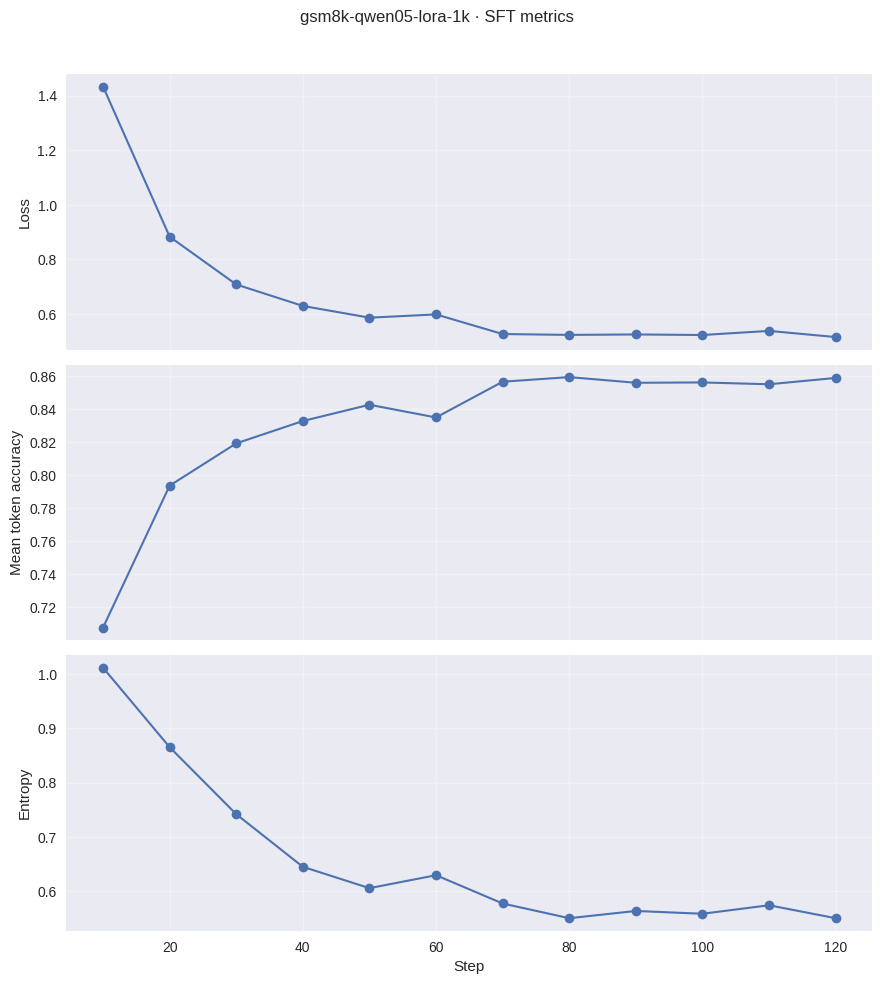

gsm8k-qwen05-lora-full: using train_logs.json, detected sft; plotting ['loss', 'mean_token_accuracy', 'entropy']
  available metrics: loss, grad_norm, learning_rate, entropy, num_tokens, mean_token_accuracy, train_loss


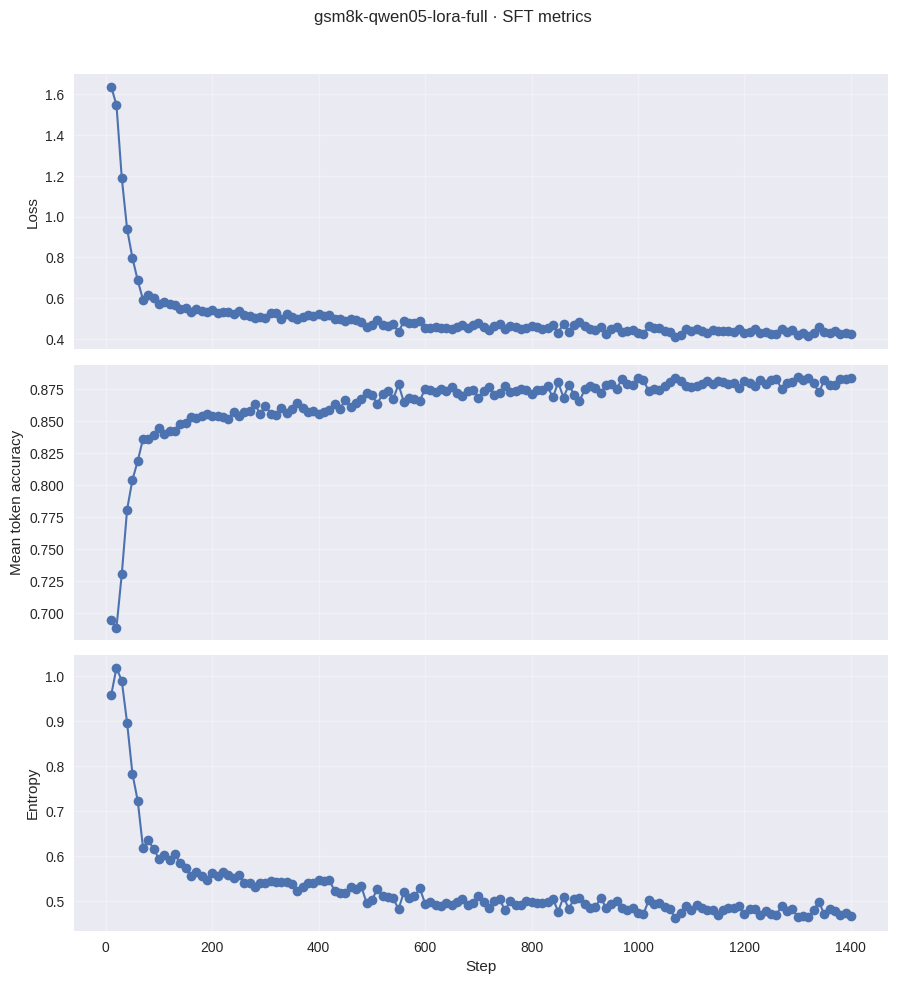

gsm8k-qwen05-lora1k-dpo5k-v1: using train_logs.json, detected dpo; plotting ['loss', 'rewards/accuracies', 'rewards/margins']
  available metrics: loss, grad_norm, learning_rate, rewards/chosen, rewards/rejected, rewards/accuracies, rewards/margins, logps/chosen, logps/rejected, logits/chosen, logits/rejected, train_loss, logps_gap, logits_gap


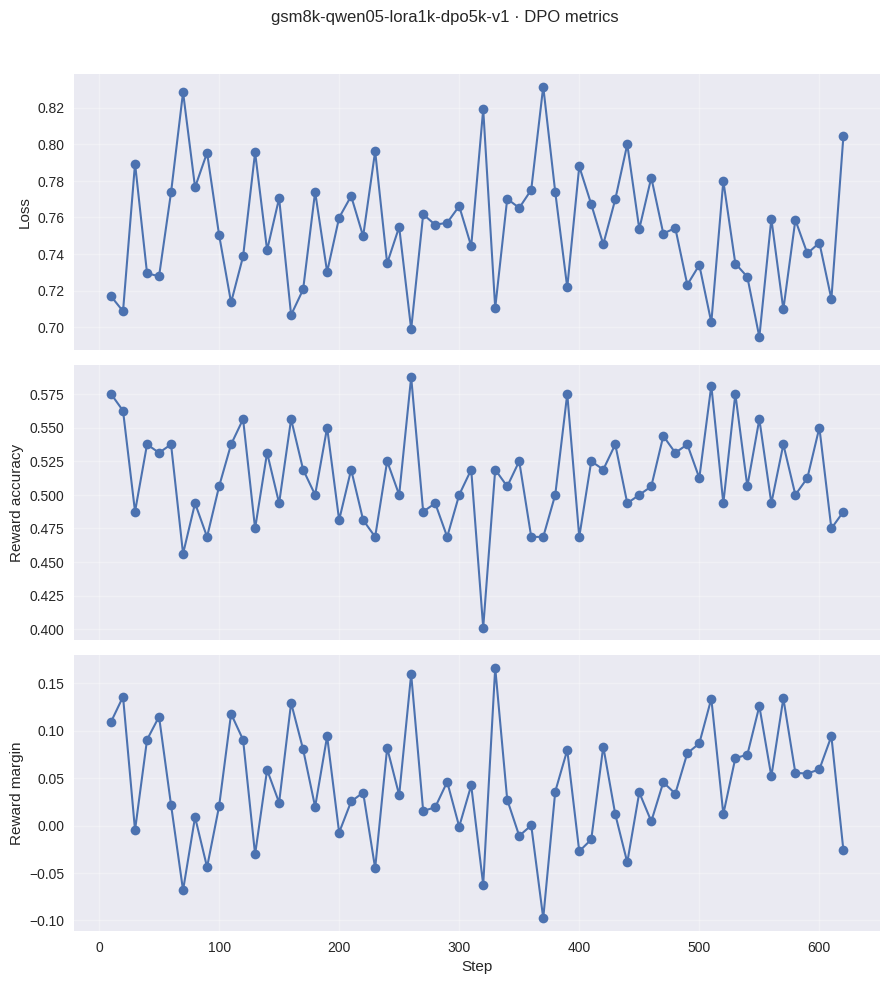

gsm8k-qwen05-lora1k-dpo1k-v3: using train_logs.json, detected dpo; plotting ['loss', 'rewards/accuracies', 'rewards/margins']
  available metrics: loss, grad_norm, learning_rate, rewards/chosen, rewards/rejected, rewards/accuracies, rewards/margins, logps/chosen, logps/rejected, logits/chosen, logits/rejected, train_loss, logps_gap, logits_gap


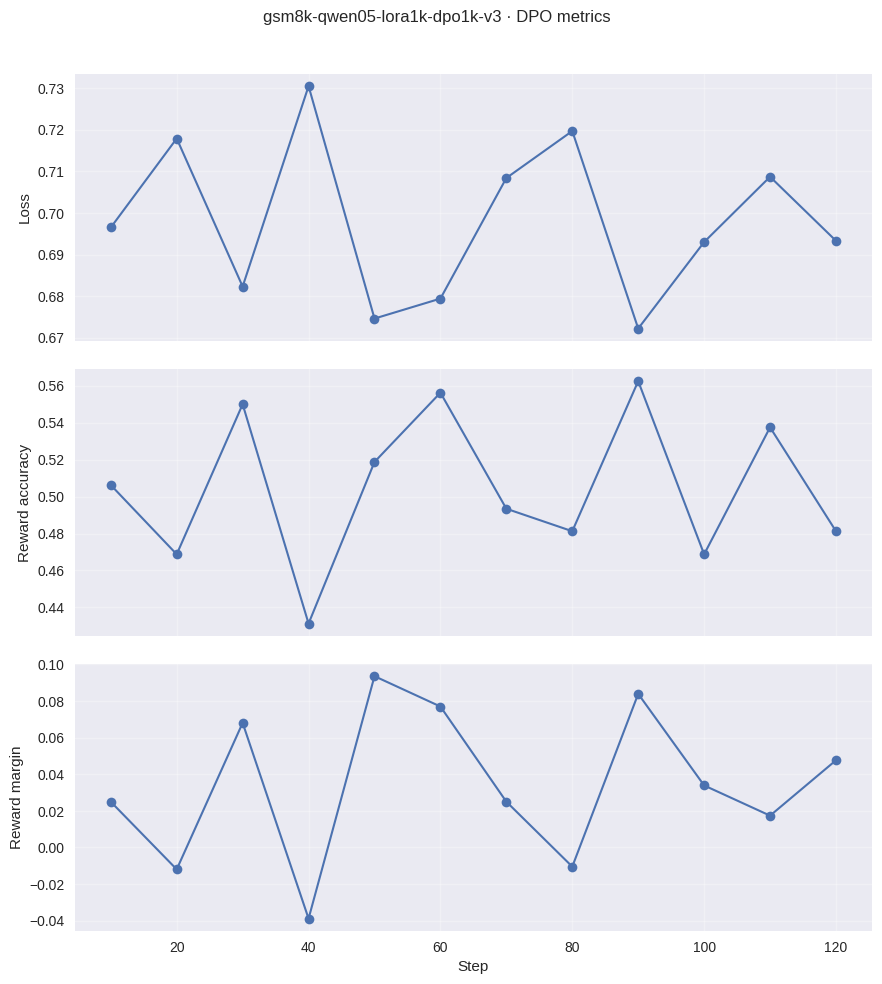

qwen05-math_chatty-1k: using train_logs.json, detected sft; plotting ['loss', 'mean_token_accuracy', 'entropy']
  available metrics: loss, grad_norm, learning_rate, entropy, num_tokens, mean_token_accuracy, train_loss


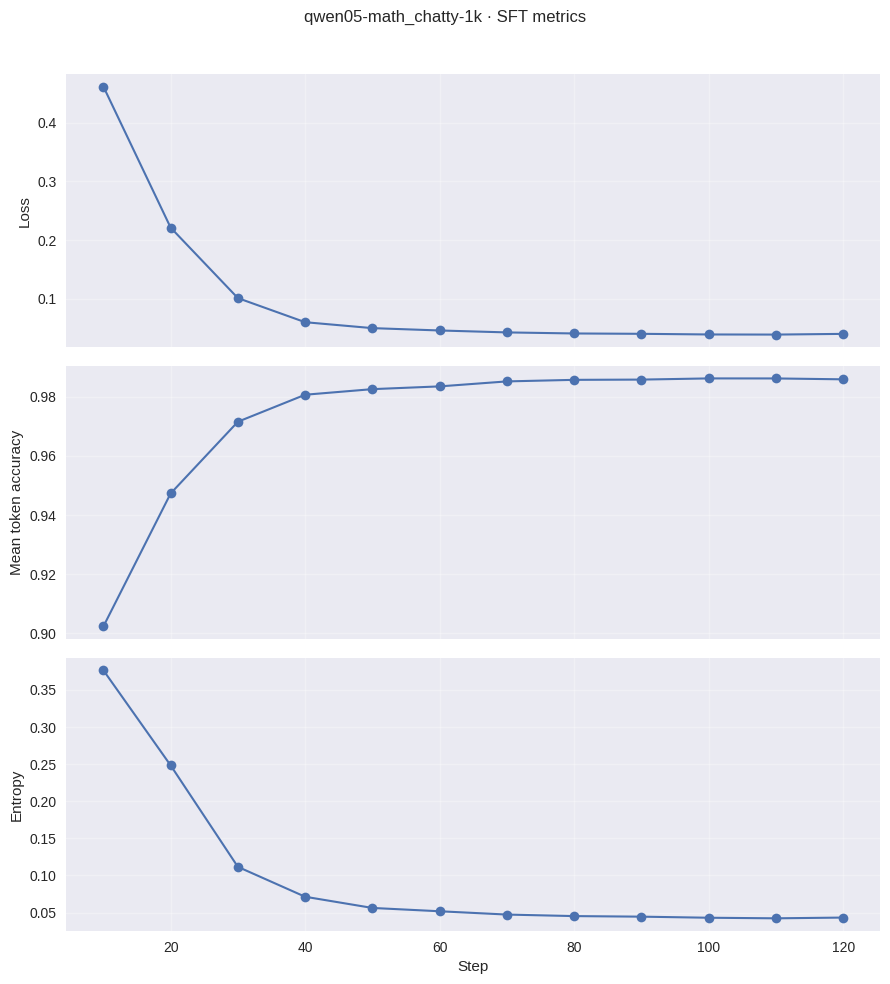

qwen05-math_partials-1k: using train_logs.json, detected sft; plotting ['loss', 'mean_token_accuracy', 'entropy']
  available metrics: loss, grad_norm, learning_rate, entropy, num_tokens, mean_token_accuracy, train_loss


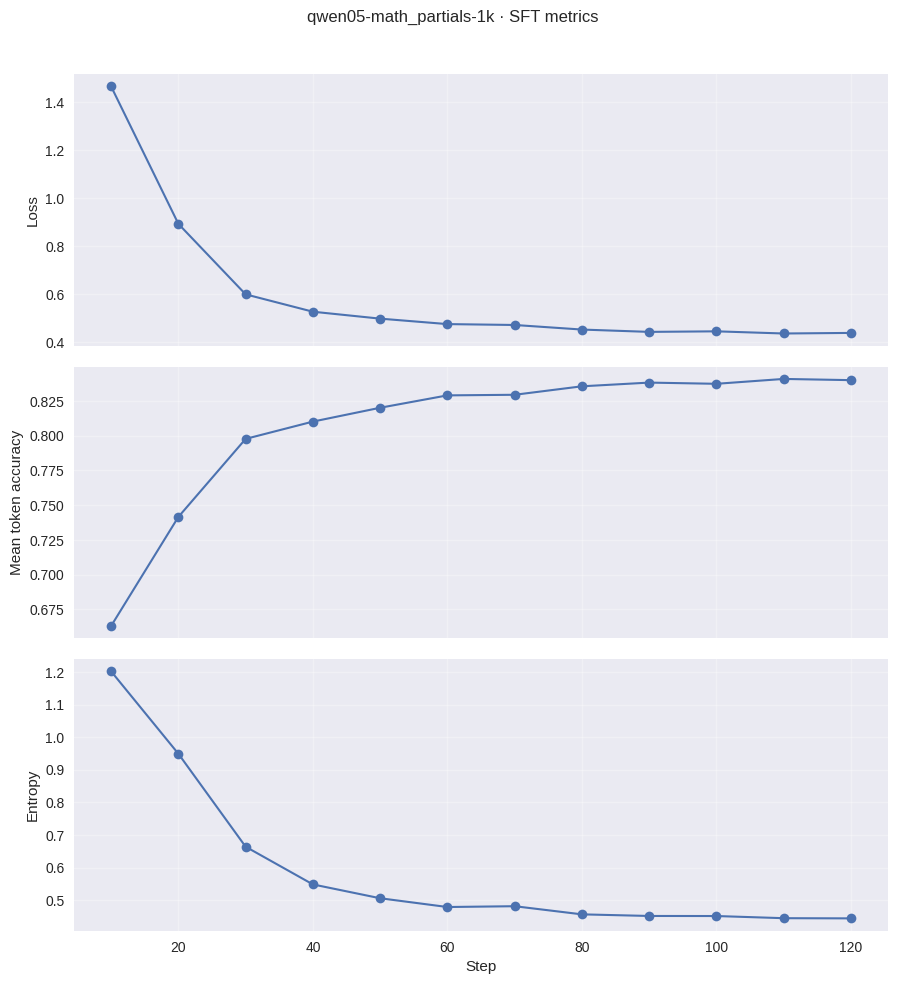

In [3]:
MODEL_NAMES = [
    "gsm8k-qwen05-lora-1k",
    "gsm8k-qwen05-lora-full",
    "gsm8k-qwen05-lora1k-dpo5k-v1",
    "gsm8k-qwen05-lora1k-dpo1k-v3",
    "qwen05-math_chatty-1k",
    "qwen05-math_partials-1k",
]

for name in MODEL_NAMES:
    model_dir = OUTPUTS_DIR / name
    raw_log, source = load_raw_logs(model_dir)
    df = clean_and_prepare_df(raw_log)
    df = augment_metrics(df)

    family = detect_training_family(df)
    metrics = pick_metrics(df, family)
    available_metrics = [c for c in df.columns if c not in {"step", "epoch"}]

    print(f"{name}: using {source}, detected {family}; plotting {[m for m, _ in metrics]}")
    print(f"  available metrics: {', '.join(available_metrics)}")

    if df.empty:
        print("  warning: log is empty, skipping plot\n")
        continue

    fig = plot_training_curves(df, metrics, name, family)
    plt.show()
